Автор:<br>Коваленко А.О.<br>Студент 2 курса магистратуры кафедры "ИУ3" МГТУ им. Н.Э. Баумана<br>

##### Ячейка под импорты модулей

In [1]:
%matplotlib inline
from model import DCGAN
import rcnn
import tensorflow as tf

from PIL import Image
from matplotlib.pyplot import imshow
from glob import glob
import numpy as np
import random
import utils
import os
import scipy.misc

data_dir = './data'

## 1. Создание обучающих выборок для генерации паттернов камуфляжей

### 1.1 Обучающая выборка на основе изображений с сайта google.com

Обучающая выборка формировалась на основе изображений, полученных в результате запроса в поисковой машине Google.com названий паттернов камуфляжей с которыми распознающая нейронная сеть справилась хуже всего.

С помошью скрипта в ячейке ниже, из запроса по названию паттерна камуфляжа брались первые 500 изображений, которые впоследствии фильтровались вручную от изображений не содержащих паттерн.

Пример изображений в результатах запроса не содержащих паттрен камуфляжа:<br>
<img src='http://airsoftpiter.ru/w/images/6/6e/90020290.jpg' width="100" height="200" align='left'>
<img src='http://s011.radikal.ru/i317/1108/fc/09d5f6eac46d.jpg' width="109" height="200" align='left'>
<img src='https://rus.mil.pl/forum/uploads/sprzet_sposn_spectre/spectre_partizan_sso-018.jpg' width="100" height="200" align='left'>

In [ ]:
#Параметры запросов в поисковую машину Google.com
amount_per_query = 500
google_queries = ['spectre camo pattern','spectre skwo pattern','cadpat pattern','marpat pattern','multicam pattern']

for query in google_queries:
    image_download.download_images(query,amount_per_query)

После получения 2500 изображений из результатов запросов Google.com, сформированная выборка, отфильтрованная от изображений не содержащих паттерн камуфляжа, состоит из ~ 1000 изображений. Пример изображений выборки приведен ниже. Все элементы преобразованны к размеру 64х64 пикселя и одному формату.

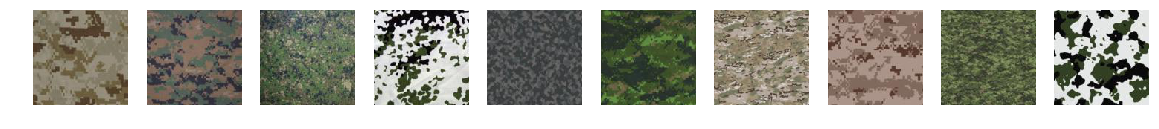

In [2]:
utils.show_images_fullsize(image_paths=glob(os.path.join(data_dir, 'camoflage_google/[0-9].jpg')),columns=10)


### 1.2 Обучающая выборка сотавленная из нарезанных на более мелкие изображения эталонных паттернов

Данная обучающая выборка основана на паттернах камуфляжей:
* Marpat
* Cadpat
* Спектр
* Спектр СКВО
* Multicam

Данный блок кода преобразует эталонные изображения паттернов камуфляжей к одинаковому формату и размеру для дальнейшей нарезки на более мелкие изображения, которые и будут составлять обучающую выборку.

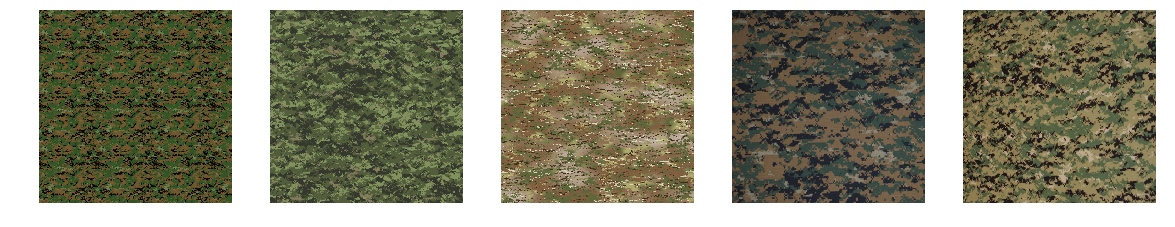

In [3]:
#Получаем список файловых путей к изображениям  
image_paths_list = glob(os.path.join(data_dir, 'camo_samples/[0-9].*g'))

#Преобразуем изображения и сохраняем
img_number = 0
for image_path in image_paths_list:
    image = Image.open(image_path)
    
    image = image.crop([0, 0, min(image.size[0],image.size[1]), min(image.size[0],image.size[1])])
    image = image.resize([1000, 1000], Image.BILINEAR)
    
    rgb_im = image.convert('RGB')
    rgb_im.save(data_dir + '/camo_patterns/' + str(img_number) + '.jpg')
    img_number+=1
#Покажем получившиестя паттерны
utils.show_images_fullsize(image_paths=glob(os.path.join(data_dir, 'camo_patterns/[0-9].*g')))

Данный блок кода формирует обучающую выборку из паттернов камуфляжей, полученных в предыдущем пункте. Элемент обучающей выборки получается вырезанием изображения размером 150x150 со случайными координатами из исходного паттерна камуфляжа, а затем сжатием его до размера 64x64 для ускорения обучения нейронной сети. Из каждого паттерна вырезаеся по 1000 более мелких изображений, формируя выборку общим размером в 5000 изображений.

In [ ]:
#Получаем список файловых путей паттернов камуфляжей
pattern_dir = image_paths_list = glob(os.path.join(data_dir, 'camo_patterns/[0-9].jpg'))

#Задаем параметры формирования элемента обучающей выборки
samples_per_pattern = 1000
crop_width = 150
crop_height = 150
resize_width = 64
resize_height = 64

#Формируем обучающую выборку
img_number = 0
for pattern_path in pattern_dir:
    pattern = Image.open(pattern_path)    
    for i in range(0,samples_per_pattern):
        #Получаем случайные координаты на паттерне
        x_offset = random.randint(0,pattern.size[0] - crop_width)
        y_offset = random.randint(0,pattern.size[1] - crop_height)
        #Вырезаем элемент размером crop_width x crop_height
        sample = pattern.crop([0 + x_offset,0 + y_offset, crop_width + x_offset, crop_height + y_offset])
        #Изменяем его размер на resize_width x resize_height
        sample = sample.resize([resize_width,resize_height], Image.BILINEAR)
        sample.save(data_dir + '/camoflage/' + str(img_number) + '.jpg', mode='RGB')
        img_number+=1

Примеры изображений обучающей выборки:

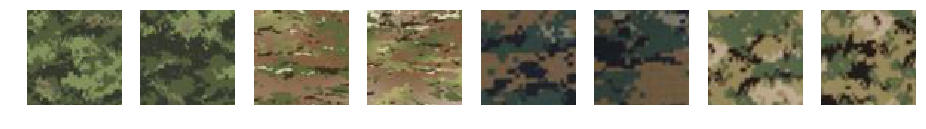

In [4]:
utils.show_images_fullsize(image_paths=glob(os.path.join(data_dir, 'camoflage/[0-5][0][0][0-1].jpg')),columns=10)

## 2.  Обучение DCGAN на составленных выборках

### 2.1  Создание модели DCGAN в фреймворке Tensorflow

Модель DCGAN описана в:

>*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.
Alec Radford, Luke Metz, Soumith Chintala. ICLR 2016.* [Arxiv 2016](https://arxiv.org/abs/1511.06434).

Программная реализация DCGAN выполнена в фреймворке tensorflow и основана на:<br>
https://github.com/carpedm20/DCGAN-tensorflow<br>

Краткое описание основной идеи архитектуры DCGAN на основе двух нейронных сетей:

1. Создается две модели, одна — генеративная (назовем ее создателем подделок), и вторая — дискриминативная (эта пусть будет экспертом)
2. Создатель подделок пытается построить на выходе фальшивку, а эксперт — отличить фальшивку от оригинала (обе модели начинают с рандомных условий, и поначалу выдают в качестве результатов шум и мусор).
3. Цель создателя подделок — сделать такой продукт, который эксперт не мог бы отличить от настоящего. Цель эксперта — максимально эффективно отличать фальшивки от оригиналов. Обе модели начинают игру друг против друга, где останется только один.

<img src="./dcgan.jpg">


В ячейке ниже задаются параметры модели.

In [2]:
flags = tf.app.flags
flags.DEFINE_integer("epoch", 30, "Количество эпох обучения")
flags.DEFINE_float("learning_rate", 0.0002, "Скорость обучения")
flags.DEFINE_float("beta1", 0.5, "Предел обучения")
flags.DEFINE_integer("train_size", np.inf, "Размер изображения обучающей выборки")
flags.DEFINE_integer("batch_size", 64, "Количество изображений в батче")
flags.DEFINE_integer("input_height", 64, "Высота изображения обучающей выборки")
flags.DEFINE_integer("input_width", 64, "Ширина изображения обучающей выборки")
flags.DEFINE_integer("output_height", 64, "Высота генерируемого изображения")
flags.DEFINE_integer("output_width", 64, "Ширина генерируемого изображения")
flags.DEFINE_string("dataset", "camoflage", "Имя обучающей выборки")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Расширения файлов обучающей выборки")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Имя директории контрольных точек")
flags.DEFINE_string("sample_dir", "samples", "Имя директории промежуточных результатов")
flags.DEFINE_boolean("train", False, "Флаг обучения (True для обучения, False для тестирования)")
flags.DEFINE_boolean("crop", False, "Флаг обрезки изображений")
flags.DEFINE_boolean("visualize", True, "Флаг визуализации")
FLAGS = flags.FLAGS

Создаем объект модели DCGAN с задаными параметрами и ускорением на GPU.

In [3]:
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

with tf.Session(config=run_config) as sess:
    dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          dataset_name=FLAGS.dataset,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir)

Обучение модели происходит с помощью скрипта ниже.

In [ ]:
'''
Обучение модели.
Не трогать ячейку, если просто хочешь загрузить обученную модель.
'''
if FLAGS.train:
    dcgan.train(FLAGS)

### 2.2 Обучение на выборке на основе изображений с сайта google.com

Так как данная выборка получилась довольно маленькой, то для нужного результата необходимо обучать нейронные сети на большом количестве эпох ~150. 150 эпох обученния на выборке с ~ 1000 изображений продлились около 4 часов на ноутбуке с процессором Core i5-4200U 2.30 ГГц и графическим процессором Nvidia GeForce GT 730M.

Посмотрим тенденцию обучения генеративной сети между разными эпохами.

***Изображения представляют из себя композицию 64 сгенерированных изображений 64х64 пикселей составляющих изображение 512х512 пикселей.***

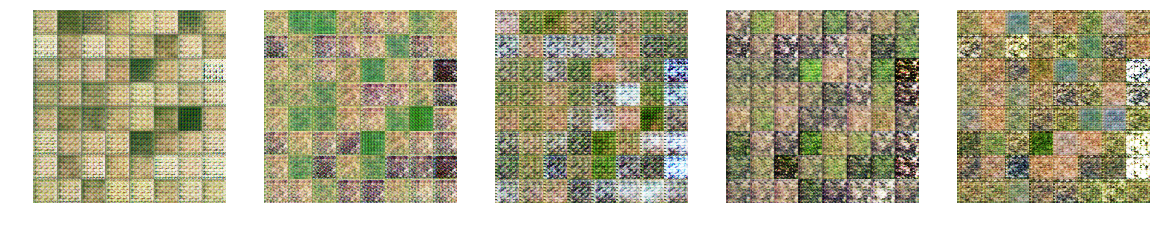

In [5]:
utils.show_images_fullsize(image_paths=glob('./samples/google_pictures_dataset/train_[0-2]*.png'))

Результат получился довольно посредственный, так как генерируемые изображения достаточно сильно отличаются друг от друга по цвету, содержат достаточно заметные артефакты и слишком отдаленно напоминают паттерны камуфляжа.

Объяснить данные результаты можно большой разрозненностью обучающей выборки, так как в ней один и тот же паттерн может иметь различный масштаб, оттенок и даже цвет.

На основе вышесказанного, эксперименты с моделью обученной на данной выборке было решено прекратить.

### 2.3 Обучение на выборке сотавленной из нарезанных на более мелкие изображения эталонных паттернов

Так как данная выборка содержит ~ 5000 изображений, то количество эпох для обучения было решено взять равным 30. Обученние продлились около 4.5 часов на ноутбуке с процессором Core i5-4200U 2.30 ГГц и графическим процессором Nvidia GeForce GT 730M.

Посмотрим тенденцию обучения генеративной сети между разными эпохами. Так менялся выход генеративной сети с 1 по 5 эпоху:

***Изображения представляют из себя композицию 64 сгенерированных изображений 64х64 пикселей составляющих изображение 512х512 пикселей.***

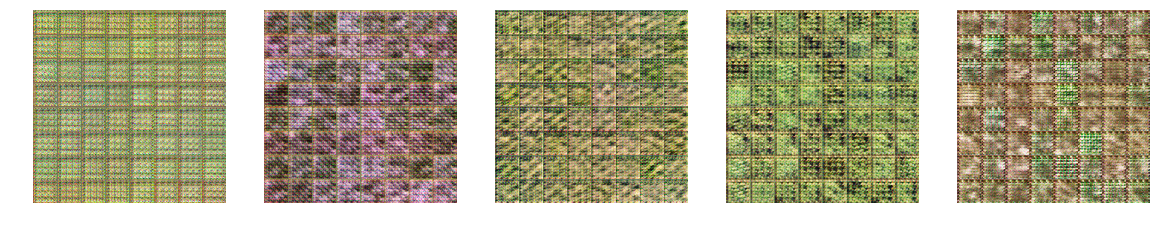

In [6]:
utils.show_images_fullsize(image_paths=glob('./samples/cropped_camo_dataset/train_[0][0-6]*.png'))

Так менялся выход генеративной сети с 11 по 15 эпохи:

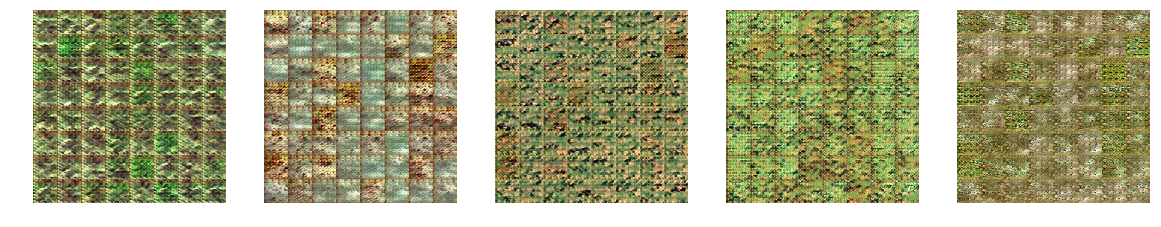

In [7]:
utils.show_images_fullsize(image_paths=glob('./samples/cropped_camo_dataset/train_[1][0-5]*.png'))

Так менялся выход генеративной сети с 26 по 30 эпохи:

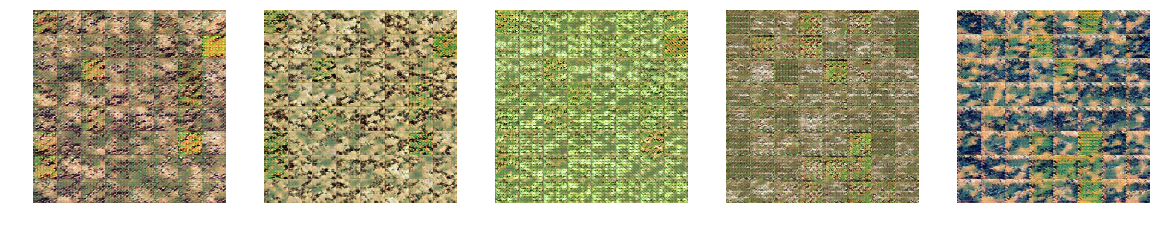

In [26]:
utils.show_images_fullsize(image_paths=glob('./samples/cropped_camo_dataset/train_[2][0-5]*.png'))

В данном случае результат обучения уже близок к ожидаемому. Генерируемые изображения в композиции составляют некий паттерн камуфляжа, основанный на паттернах из обучающей выборки.

Продолжим эксперименты с моделью, обученной на данной выборке.

## 3. Распознавание генерируемого камуфляжа

Загрузим обученную генертивную модель.

In [4]:
'''
Загрузить модель, обученную на предыущем  шаге.
'''
if not dcgan.load(FLAGS.checkpoint_dir)[0]:
    raise Exception("[!] Train a model first, then run test mode")

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint\camoflage_64_64_64\DCGAN.model-2002
 [*] Success to read DCGAN.model-2002


### 3.1 Список распознающих моделей

После того как мы обучили модель, можно приступить к экспериментам с распознаванием генирируемого камуфляжа. Распознавание будет проводиться уже обученными моделями нейронных сетей.

1. RCNN обученная на <a href='http://www.image-net.org/challenges/LSVRC/2013/'>ILSVRC2013</a> взята из https://github.com/BVLC/caffe
>*Rich feature hierarchies for accurate object detection and semantic segmentation. Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. CVPR 2014.* [Arxiv 2014](http://arxiv.org/abs/1311.2524).

2. 

В качестве тестового набора будет выступать набор изображений людей в камуфляже, которые все модели гарантированно полностью распознают. 

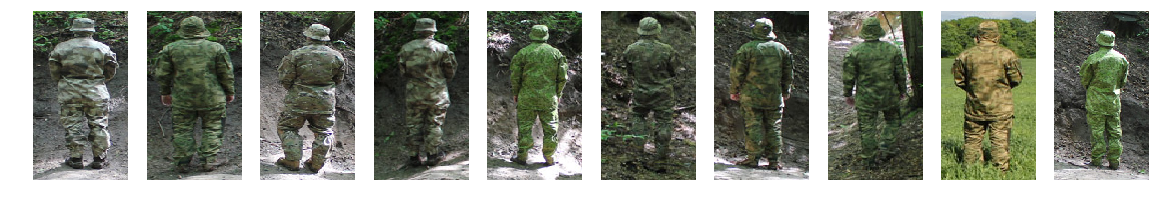

In [4]:
utils.show_images_fullsize(image_paths=glob('./data/person/person_sample/*.*g'),columns=10)

### 3.2 RCNN обученая на ILSVRC2013

Для начала проверим распознает ли нейронная сеть все изображения людей 

In [5]:
rcnn.classify_batch(glob('./data/person/person_sample/*.*g'))

CaffeNet found.
Изображение-1 --- Распознанный класс:  123 n00007846 person
Изображение-2 --- Распознанный класс:  123 n00007846 person
Изображение-3 --- Распознанный класс:  123 n00007846 person
Изображение-4 --- Распознанный класс:  123 n00007846 person
Изображение-5 --- Распознанный класс:  123 n00007846 person
Изображение-6 --- Распознанный класс:  123 n00007846 person
Изображение-7 --- Распознанный класс:  123 n00007846 person
Изображение-8 --- Распознанный класс:  123 n00007846 person
Изображение-9 --- Распознанный класс:  123 n00007846 person
Изображение-10 --- Распознанный класс:  123 n00007846 person
Распознанно 10 из 10 (100.0%)


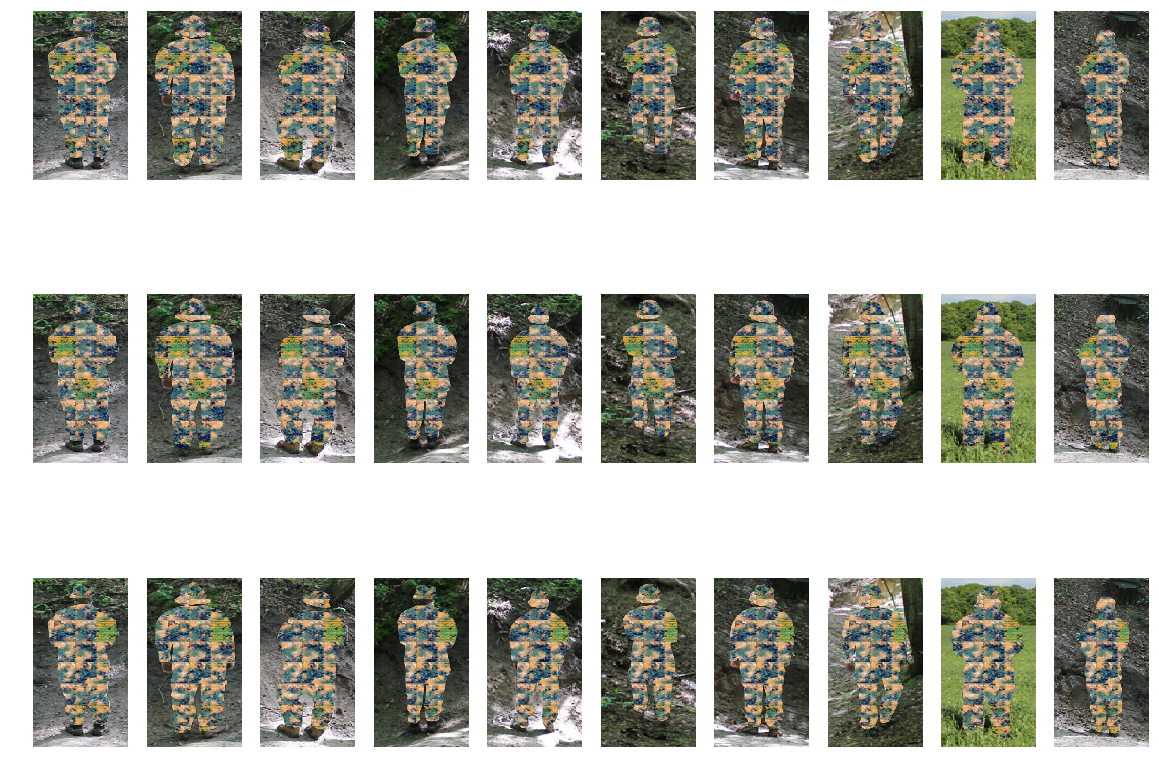

In [6]:
utils.generate_camo_person(dcgan.sess, dcgan, FLAGS,3)

In [7]:
rcnn.classify_batch(glob('./samples/generated_camo_person/person*.png'))

CaffeNet found.
Изображение-1 --- Распознанный класс:  67 n03991062 flower pot
Изображение-2 --- Распознанный класс:  123 n00007846 person
Изображение-3 --- Распознанный класс:  110 n03764736 milk can
Изображение-4 --- Распознанный класс:  195 n04557648 water bottle
Изображение-5 --- Распознанный класс:  195 n04557648 water bottle
Изображение-6 --- Распознанный класс:  195 n04557648 water bottle
Изображение-7 --- Распознанный класс:  123 n00007846 person
Изображение-8 --- Распознанный класс:  123 n00007846 person
Изображение-9 --- Распознанный класс:  54 n03188531 diaper
Изображение-10 --- Распознанный класс:  187 n01662784 turtle
Изображение-11 --- Распознанный класс:  195 n04557648 water bottle
Изображение-12 --- Распознанный класс:  110 n03764736 milk can
Изображение-13 --- Распознанный класс:  125 n07753275 pineapple
Изображение-14 --- Распознанный класс:  125 n07753275 pineapple
Изображение-15 --- Распознанный класс:  110 n03764736 milk can
Изображение-16 --- Распознанный класс:  

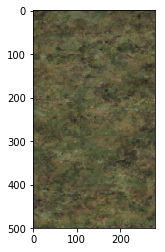

In [4]:
image_paths=glob(os.path.join(data_dir, 'camo_patterns/[0-9].*g'))
avg_camo = utils.image_avg_sum(image_paths)
imshow(avg_camo)
scipy.misc.imsave('./samples/generated_camo_person/avrg_camo.png',avg_camo)

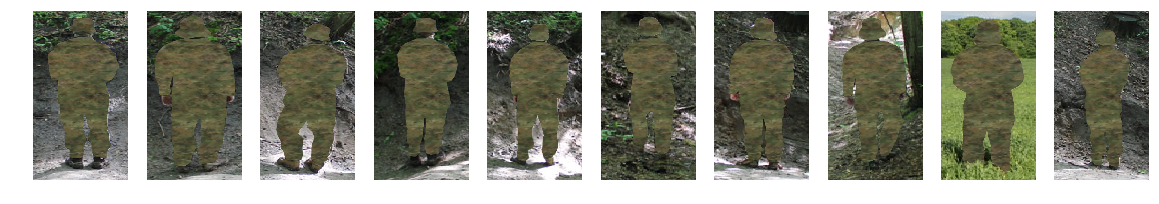

In [13]:
utils.pattern_camo_person(avg_camo)

In [19]:
rcnn.classify_batch(glob('./samples/generated_camo_person/person_avrg*.png'))

CaffeNet found.
Изображение-1 --- Распознанный класс:  123 n00007846 person
Изображение-2 --- Распознанный класс:  123 n00007846 person
Изображение-3 --- Распознанный класс:  7 n02764044 axe
Изображение-4 --- Распознанный класс:  123 n00007846 person
Изображение-5 --- Распознанный класс:  123 n00007846 person
Изображение-6 --- Распознанный класс:  171 n04336792 stretcher
Изображение-7 --- Распознанный класс:  123 n00007846 person
Изображение-8 --- Распознанный класс:  123 n00007846 person
Изображение-9 --- Распознанный класс:  63 n02503517 elephant
Изображение-10 --- Распознанный класс:  164 n04270147 spatula
Распознанно 6 из 10 (60.0%)
